#### <strong>第三次作品：分類器的原理與評比實驗(資料二)</strong>
學號：410978002

姓名：謝元皓

<font color=skyblue>資料描述</font>：
第二筆資料 來自 AT&T 40 個人的人臉影像共 400 張，每張大小 64×64。
 <hr>

### 程式碼解析
這段程式碼主要用於顯示一個人臉數據集中的圖像總匯。讓我們逐步解釋：

1. `import` 語句導入了三個庫：
   - `pandas` 库，對數據進行操作和分析。
   - `numpy` 库，用於數學計算。
   - `matplotlib.pyplot` 库，用於繪製圖表。

2. `show_montage` 函數定義了一個函數，用於顯示一個由多個圖像組成的總匯。它接受五個參數：
   - `X`：包含圖像數據的二維數組。
   - `n`：每個圖像的行數（高度）。
   - `m`：每個圖像的列數（寬度）。
   - `h`：總匯的行數。
   - `w`：總匯的列數。

3. `fig, axes = plt.subplots(h, w, figsize=(w, h))` 創建了一個包含 `h` 行 `w` 列的子圖表，並指定了總匯的大小。

4. `if X.shape[1] < w * h:` 檢查 `X` 中的圖像數量是否小於預期的總匯大小。如果是，則添加一些填充以保證總匯的每個位置都有圖像。

5. `for i, ax in enumerate(axes.flat):` 通過 `enumerate` 函數遍歷所有子圖表。

6. `ax.imshow(X[:,i].reshape(m, n).T, cmap='gray')` 用灰度顯示第 `i` 張圖像，`reshape` 函數將一維數組調整為 `m` 行 `n` 列的矩陣，然後 `.T` 轉置矩陣以適應 matplotlib 的預期格式。

7. `ax.set_xticks([])` 和 `ax.set_yticks([])` 設置不顯示刻度。

8. `plt.show()` 顯示總匯。

9. `df = pd.read_csv('face_data.csv')` 從名為 `'face_data.csv'` 的 CSV 文件中讀取數據集。

10. `n_persons = df['target'].nunique()` 獲取數據集中不同目標（人物）的數量。

11. `X = np.array(df.drop('target', axis=1))` 從數據集中刪除目標列，並將其轉換為 NumPy 數組。

12. `y = np.array(df['target'])` 創建一個包含目標（人物）的 NumPy 數組。

13. `n, m = 64, 64` 設置圖像的尺寸。

14. `show_montage(X.T, n, m, 10, 10)` 將圖像數據進行轉置（因為函數期望每列是一個圖像），然後顯示圖像的總匯，每個總匯包含 10 行 10 列的圖像。

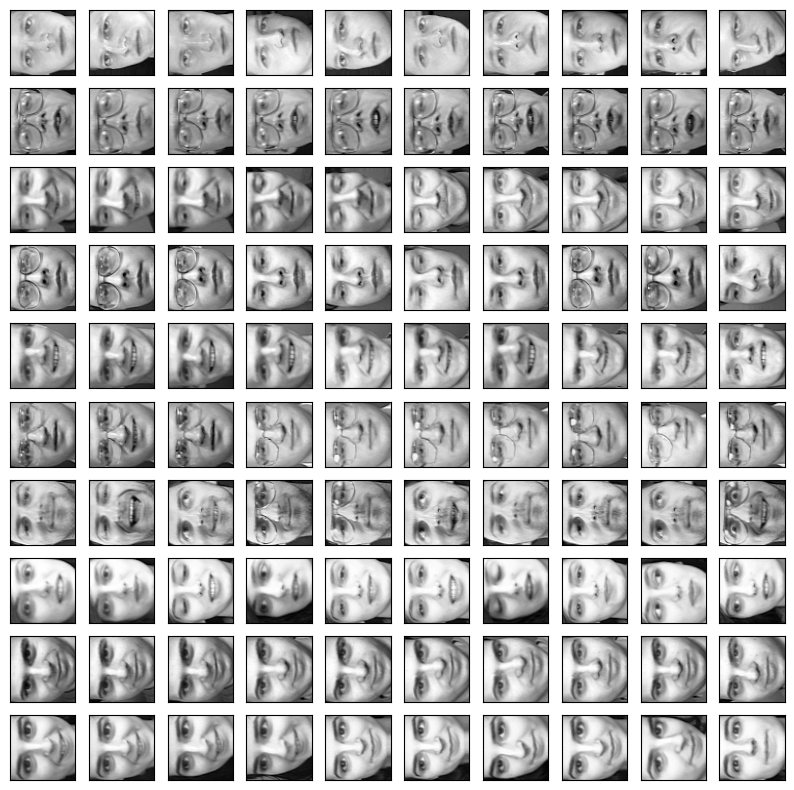

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def show_montage(X, n, m, h, w):

    fig, axes = plt.subplots(h, w, figsize=(w, h))
    if X.shape[1] < w * h:
        X = np.c_[X, np.zeros((X.shape[0], w*h-X.shape[1]))]
    for i, ax in enumerate(axes.flat):
        ax.imshow(X[:,i].reshape(m, n).T, cmap='gray')
        ax.set_xticks([])
        ax.set_yticks([])
    plt.show()

df = pd.read_csv('face_data.csv')
n_persons = df['target'].nunique()
X = np.array(df.drop('target', axis = 1)) #400*4096
y = np.array(df['target'])
n, m = 64, 64
show_montage(X.T, n, m, 10, 10)

### 資料讀取
- 將資料拆成分成訓練資料跟測試資料。
- 訓練和測試資料比例為 $4:1$。
- 先將原始資料標準化(必須將訓練和測試資料分開標準化)。
- 再運用PCA降維創造出主成分資料。
- 順便列印出訓練資料跟測試資料的大小。

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
# 讀取資料集
face_df = pd.read_csv('face_data.csv')

# 將資料分成特徵和標籤
X = np.array(face_df.iloc[:, :-1]) # 排 除 最 後 一 欄 標 籤
y = np.array(face_df.iloc[:, -1])

# 分割資料集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# Standardize data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.fit_transform(X_test)

# 主成分分析 (PCA)
proportion = 0.8
pca = PCA(proportion)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

print(X_train_scaled.shape, y_train.shape)
print(X_test_scaled.shape, y_test.shape) 
print(X_train_pca.shape)
print(X_test_pca.shape)

(320, 4096) (320,)
(80, 4096) (80,)
(320, 26)
(80, 26)


## 分類器一: 多元邏吉斯回歸
- 需使用套件 sklearn 中的 LogisticRegression
- 運用Cross validation 的方式，找出最佳參數。
- 需使用到sklearn 中 GridSearchCV套件。
- 找出最好參數後，再用此訓練及測試資料。
<hr> 

### step1 運用 Cross validation 的方式，找出最佳的參數
#### 套件介紹
1. LogisticRegression 為Scikit-learn庫中的Logistic Regression模型
2. GridSearchCV, StratifiedShuffleSpli 為 Scikit-learn庫中的網格搜索(GridSearchCV)和分層洗牌分割(StratifiedShuffleSplit)模組。網格搜索用於選擇最佳的超參數，分層洗牌分割用於交叉驗證。
3. datetime 為Python的datetime模組，用於處理日期和時間。

### 程式碼解析
這段程式碼用於對 logistic 回歸模型進行超參數調整，具體解釋如下：

1. `from sklearn.linear_model import LogisticRegression`: 從 scikit-learn 中導入 logistic 回歸模型。

2. `from sklearn.model_selection import GridSearchCV, StratifiedShuffleSplit`: 從 scikit-learn 中導入網格搜索交叉驗證和分層隨機分割交叉驗證。

3. `opts = dict(tol=1e-6, max_iter=int(1e6))`: 定義一個字典 `opts` 包含 logistic 回歸模型的超參數設置，其中 `tol` 是容忍的停止標準，`max_iter` 是最大迭代次數。

4. `parameters = {'solver':['lbfgs', 'liblinear', 'newton-cg'], 'C':[0.1, 1, 10]}`: 定義一個字典 `parameters` 包含要調整的超參數範圍，其中 `'solver'` 是優化算法，`'C'` 是正則化強度。

5. `cv = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=0)`: 使用分層隨機分割交叉驗證，創建一個交叉驗證對象 `cv`，其中包括 5 折交叉驗證，測試集大小為數據集的 20%，並指定隨機種子為 0。

6. `grid = GridSearchCV(estimator=LogisticRegression(**opts), param_grid=parameters, cv=cv, scoring=['accuracy','f1_macro'], refit="accuracy")`: 使用網格搜索交叉驗證 `GridSearchCV`，指定 logistic 回歸模型作為估計器，超參數範圍為 `parameters`，交叉驗證為 `cv`，評分標準為準確度和 F1 分數（用於多類分類），並指定將使用準確度進行模型重新擬合。

7. `grid.fit(X_train_scaled, y_train)`: 使用訓練數據 `X_train_scaled` 和對應的標籤 `y_train` 對網格搜索對象進行擬合，以找到最佳的超參數組合。

8. `print(grid.best_params_)`: 打印出最佳超參數組合。

9. `print(grid.best_score_)`: 打印出使用最佳超參數組合時的交叉驗證準確度。

10. `print(grid.best_estimator_)`: 打印出使用最佳超參數組合時的最佳估計器（模型）。

In [8]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import  GridSearchCV, \
                        StratifiedShuffleSplit

opts = dict(tol = 1e-6, max_iter = int(1e6)) # parameters for LogisticRegression
parameters = {'solver':['lbfgs', 'liblinear', 'newton-cg'], 
              'C':[0.1, 1, 10]} # parameters for GridSearchCV
cv = StratifiedShuffleSplit(n_splits=5, test_size=0.2, \
                            random_state=0) # 5-fold CV
grid = GridSearchCV(estimator=LogisticRegression(**opts), \
                param_grid=parameters, cv=cv, 
                scoring=['accuracy','f1_macro'], refit="accuracy")
grid.fit(X_train_scaled, y_train)

print(grid.best_params_)
print(grid.best_score_)
print(grid.best_estimator_)



{'C': 0.1, 'solver': 'lbfgs'}
0.971875
LogisticRegression(C=0.1, max_iter=1000000, tol=1e-06)


### step2 測試資料之準確率回報
- 運用上一步找出最佳參數訓練資料，計算各項準確率

In [2]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
# 初始化羅吉斯回歸分類器並使用上一步找出的最佳參數
logreg = LogisticRegression(C=0.1, solver='lbfgs',tol = 1e-6, max_iter = int(1e6), verbose=1)

# 使用原始資料進行訓練及測試
logreg.fit(X_train_scaled, y_train)
y_pred = logreg.predict(X_test_scaled)
accuracy_orig = accuracy_score(y_test, y_pred)

# 使用主成分資料進行訓練及測試
logreg.fit(X_train_pca, y_train)
y_pred_pca = logreg.predict(X_test_pca)
accuracy_pca = accuracy_score(y_test, y_pred_pca)

print("Accuracy using original data:", accuracy_orig)
print("Accuracy using principal components:", accuracy_pca)

Accuracy using original data: 0.9625
Accuracy using principal components: 0.925


< 結果與討論 >
- 上述這段程式碼將使用原始資料和使用PCA降維後的主成分資料來訓練和測試多元羅吉斯回歸分類器。
- 它會列印出兩種情況下的準確率(原始資料的準確率為96.25%，主成分後的資料準確率為92.5%)
<hr>


## 分類器二: 支援向量機 (Support Vector Machine)


In [8]:
from sklearn.svm import SVC
from sklearn.model_selection import  GridSearchCV, \
                        StratifiedShuffleSplit

opts = dict(tol = 1e-6, max_iter = int(1e6)) # parameters for LogisticRegression
parameters = {'kernel':[ 'rbf', 'poly', 'sigmoid'], 'gamma': [0.1, 0.01, 0.001], 
              'C':[0.1, 1, 10]} # parameters for GridSearchCV
cv = StratifiedShuffleSplit(n_splits=5, test_size=0.2, \
                            random_state=0) # 5-fold CV
grid = GridSearchCV(estimator=SVC(**opts), \
                param_grid=parameters, cv=cv, 
                scoring=['accuracy','f1_macro'], refit="accuracy")
grid.fit(X_train_scaled, y_train)

print(grid.best_params_)
print(grid.best_score_)
print(grid.best_estimator_)

{'C': 10, 'gamma': 0.001, 'kernel': 'rbf'}
0.809375
SVC(C=10, gamma=0.001, max_iter=1000000, tol=1e-06)


In [9]:
#原始資料標準化後的生成分類報告
from sklearn.svm import SVC, LinearSVC
from sklearn.metrics import classification_report
C = 10 # SVM regularization parameter
gamma = 0.001
opts = dict(C = C, gamma = gamma, tol = 1e-6, max_iter = int(1e6))
clf_svm = SVC(kernel='rbf', **opts)
clf_svm.fit(X_train_scaled, y_train)
predictions = clf_svm.predict(X_test_scaled)
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.11      1.00      0.20         1
           1       1.00      1.00      1.00         1
           2       1.00      0.67      0.80         3
           3       1.00      1.00      1.00         2
           4       0.00      0.00      0.00         0
           5       1.00      1.00      1.00         2
           6       1.00      0.33      0.50         3
           7       1.00      0.33      0.50         3
           8       1.00      0.75      0.86         4
           9       1.00      1.00      1.00         2
          10       1.00      1.00      1.00         1
          11       1.00      1.00      1.00         2
          12       0.00      0.00      0.00         0
          13       1.00      1.00      1.00         2
          14       1.00      1.00      1.00         3
          15       1.00      1.00      1.00         1
          16       1.00      1.00      1.00         1
          17       1.00    

d:\python_venv\ml_evnv\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\python_venv\ml_evnv\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\python_venv\ml_evnv\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\python_venv\ml_evnv\Lib\site-packages\sklearn\metri

In [10]:
from sklearn.svm import SVC
from sklearn.model_selection import  GridSearchCV, \
                        StratifiedShuffleSplit

opts = dict(tol = 1e-6, max_iter = int(1e6)) # parameters for LogisticRegression
parameters = {'kernel':[ 'rbf', 'poly', 'sigmoid'], 'gamma': [0.1, 0.01, 0.001], 
              'C':[0.1, 1, 10]} # parameters for GridSearchCV
cv = StratifiedShuffleSplit(n_splits=5, test_size=0.2, \
                            random_state=0) # 5-fold CV
grid = GridSearchCV(estimator=SVC(**opts), \
                param_grid=parameters, cv=cv, 
                scoring=['accuracy','f1_macro'], refit="accuracy")
grid.fit(X_train_pca, y_train)

print(grid.best_params_)
print(grid.best_score_)
print(grid.best_estimator_)

{'C': 1, 'gamma': 0.001, 'kernel': 'rbf'}
0.896875
SVC(C=1, gamma=0.001, max_iter=1000000, tol=1e-06)


In [11]:
#主成分資料的生成分類報告
from sklearn.svm import SVC, LinearSVC
from sklearn.metrics import classification_report
C = 1 # SVM regularization parameter
gamma = 0.001
opts = dict(C = C, gamma = gamma, tol = 1e-6, max_iter = int(1e6))
clf_svm = SVC(kernel='rbf', **opts)
clf_svm.fit(X_train_pca, y_train)
predictions = clf_svm.predict(X_test_pca)
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.33      1.00      0.50         1
           1       1.00      1.00      1.00         1
           2       1.00      1.00      1.00         3
           3       1.00      1.00      1.00         2
           4       0.00      0.00      0.00         0
           5       1.00      1.00      1.00         2
           6       1.00      1.00      1.00         3
           7       1.00      0.67      0.80         3
           8       1.00      0.75      0.86         4
           9       1.00      1.00      1.00         2
          10       1.00      1.00      1.00         1
          11       1.00      1.00      1.00         2
          13       1.00      1.00      1.00         2
          14       1.00      1.00      1.00         3
          15       1.00      1.00      1.00         1
          16       1.00      1.00      1.00         1
          17       1.00      1.00      1.00         2
          20       1.00    

d:\python_venv\ml_evnv\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\python_venv\ml_evnv\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\python_venv\ml_evnv\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\python_venv\ml_evnv\Lib\site-packages\sklearn\metri

## 分類器三: 神經網路 (Neural Network)

**一樣先執行cross validation**
這段程式碼是用來進行 MLPClassifier 的參數調優。逐行解釋：

1. `from sklearn.neural_network import MLPClassifier`: 從 Scikit-Learn 中導入 MLPClassifier，這是一個多層感知機分類器，用於進行神經網路相關的分類任務。

2. `from sklearn.model_selection import GridSearchCV`: 從 Scikit-Learn 中導入 GridSearchCV，用於進行參數的網格搜索和交叉驗證。

3. `opts = dict(tol=1e-6, max_iter=int(1e6))`: 創建了一個字典 `opts`，其中包含了 MLPClassifier 的一些參數設置，例如 `tol`（容忍度）和 `max_iter`（最大迭代次數）。

4. `param_grid`: 定義了一個參數網格，包含了我們想要調優的參數及其可能的取值範圍。這些參數包括隱藏層大小、激活函數、求解器和 alpha（正則化參數）。

5. `cv`: 定義了交叉驗證的策略。在這裡，使用了 StratifiedShuffleSplit，它會將數據集分成 5 個子集，每個子集都保持類別分佈的一致性，並且使用 20% 的數據作為測試集。

6. `grid = GridSearchCV(estimator=MLPClassifier(**opts), param_grid=param_grid, cv=cv, scoring=['accuracy', 'f1_macro'], refit="accuracy")`: 初始化了一個 GridSearchCV 對象，指定了要搜索的模型（MLPClassifier），參數網格，交叉驗證策略，評估指標（這裡使用了 accuracy 和 f1_macro），以及要根據哪個指標來選擇最佳模型（在這裡是 accuracy）。

7. `grid.fit(X_train_scaled, y_train)`: 調用 GridSearchCV 對象的 fit 方法，開始在訓練集上進行參數搜索和交叉驗證。

8. `print(grid.best_params_)`: 打印出搜索過程中得到的最佳參數組合。

9. `print(grid.best_score_)`: 打印出使用最佳參數組合在交叉驗證中獲得的最佳得分。

10. `print(grid.best_estimator_)`: 打印出具有最佳參數的最佳估算器（即最佳模型）的詳細信息。

總的來說，這段程式碼是一個完整的參數調優流程，通過網格搜索和交叉驗證，找到了 MLPClassifier 的最佳參數組合，以提高其在給定數據集上的性能。

In [12]:
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV
opts = dict(tol = 1e-6, max_iter = int(1e6)) 
param_grid = {
    'hidden_layer_sizes': [(100,), (50, 50), (25, 25, 25)],
    'activation': ['relu', 'tanh', 'logistic'],
    'solver': ['sgd', 'adam'],
    'alpha': [0.0001, 0.001, 0.01],
}
cv = StratifiedShuffleSplit(n_splits=5, test_size=0.2, \
                            random_state=0) # 5-fold CV
grid = GridSearchCV(estimator=MLPClassifier(**opts), \
                param_grid=param_grid, cv=cv, 
                scoring=['accuracy','f1_macro'], refit="accuracy")
grid.fit(X_train_scaled, y_train)

print(grid.best_params_)
print(grid.best_score_)
print(grid.best_estimator_)

d:\python_venv\ml_evnv\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:698: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")
d:\python_venv\ml_evnv\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:698: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")
d:\python_venv\ml_evnv\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:698: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")
